In [100]:
#!/usr/bin/python
# vim:ts=4:sts=4:sw=4:et:wrap:ai:fileencoding=utf-8:
import json
import math
import numpy as np
import pandas as pd
from random import random
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from scipy.optimize import curve_fit
from scipy.misc import factorial
from IPython.display import Image
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Preparing data
##### assistances without shots (shot region=0) means assistances where the striker couldn't get the ball

In [2]:
df = pd.read_csv("data/shots_2016.csv", sep=";")

In [3]:
columns = df.columns.tolist()
columns[:21]
cols_to_use = columns[:21] # drop unused columns
cols_to_use
shots_df = pd.read_csv("data/shots_2016.csv", sep=";", usecols=cols_to_use)
shots_df.head()

,index,week,goal,minute,shot_player,assistance_player,team,opponent,region_assistance,region_shot,...,at_home,type_of_play,type_of_shot,dribble_before_shot,deep_pass,cross,counter_attack,good_chance,defense_mistake,dangerous_shot
0,1,1,1,NaN,everton,Willian Arao,Flamengo,Sport,5,3,...,1,collective,foot,0,0,1,0,1,1,1
1,2,1,0,NaN,Diego Souza,-,Sport,Flamengo,0,26,...,0,direct_fk,foot,0,0,0,0,0,0,0
2,3,1,0,NaN,everton,Mancuello,Flamengo,Sport,28,5,...,1,collective,foot,0,1,0,0,1,0,0
3,4,1,0,NaN,Guerrero,Everton,Flamengo,Sport,18,18,...,1,collective,foot,0,0,0,0,0,0,0
4,5,1,0,NaN,Rodinei,-,Flamengo,Sport,0,15,...,1,individual,foot,1,0,0,0,0,0,0


In [4]:
match_df = pd.read_csv("data/match_data_2016.csv", sep=";")
match_df.head()

,week,home_team,away_team,home_goals,away_goals,week_day,time,home_passes,home_wrong_passes,away_passes,...,home_shots_on_target,home_shots_off_target,away_shots_on_target,away_shots_off_target,home_fouls,away_fouls,home_tackles,home_wrong_tackles,away_tackles,away_wrong_tackles
0,1,Flamengo,Sport,1,0,SAT,16,471,41,322,...,5,6,1,0,18,15,24,1,19,3
1,1,Atletico MG,Santos,1,0,SAT,18,249,37,444,...,6,15,4,8,17,11,26,6,9,2
2,1,Coritiba,Cruzeiro,1,0,SAT,21,304,41,349,...,6,8,1,3,20,22,17,3,19,2
3,1,Corinthians,Gremio,0,0,SUN,16,470,44,283,...,1,15,2,4,12,19,24,1,22,3
4,1,Botafogo,Sao Paulo,0,1,SUN,11,434,32,189,...,6,5,1,3,8,10,9,1,17,4


In [5]:
shots_df["team"] = shots_df["team"].str.strip()     # some strings have unecessary whitespace at the end
shots_df["opponent"] = shots_df["opponent"].str.strip()
shots_df["shot_player"] = shots_df["shot_player"].str.strip()
shots_df["assistance_player"] = shots_df["assistance_player"].str.strip()

match_df["home_team"] = match_df["home_team"].str.strip()
match_df["away_team"] = match_df["away_team"].str.strip()
set(shots_df["team"])

{'America',
 'Atletico MG',
 'Atletico PR',
 'Botafogo',
 'Chapecoense',
 'Corinthians',
 'Coritiba',
 'Cruzeiro',
 'Figueirense',
 'Flamengo',
 'Fluminense',
 'Gremio',
 'Internacional',
 'Palmeiras',
 'Ponte Preta',
 'Santa Cruz',
 'Santos',
 'Sao Paulo',
 'Sport',
 'Vitoria'}

In [6]:
shots_df.dtypes

index                    int64
week                     int64
goal                     int64
minute                 float64
shot_player             object
assistance_player       object
team                    object
opponent                object
region_assistance        int64
region_shot              int64
goal_difference          int64
at_home                  int64
type_of_play            object
type_of_shot            object
dribble_before_shot      int64
deep_pass                int64
cross                    int64
counter_attack           int64
good_chance              int64
defense_mistake          int64
dangerous_shot           int64
dtype: object

In [7]:
# the values for the regions of the shots and assistances aren't numerical, but categorical
shots_df["region_shot"] = shots_df["region_shot"].astype('category')
shots_df["region_assistance"] = shots_df["region_assistance"].astype('category')

# the values of binary variables aren't numerical - we must convert to boolean
bool_map = {1: True, 0: False}

shots_df["goal"] = shots_df["goal"].map(bool_map)
shots_df["at_home"] = shots_df["at_home"].map(bool_map)
shots_df["dribble_before_shot"] = shots_df["dribble_before_shot"].map(bool_map)
shots_df["deep_pass"] = shots_df["deep_pass"].map(bool_map)
shots_df["cross"] = shots_df["cross"].map(bool_map)
shots_df["counter_attack"] = shots_df["counter_attack"].map(bool_map)
shots_df["good_chance"] = shots_df["good_chance"].map(bool_map)
shots_df["defense_mistake"] = shots_df["defense_mistake"].map(bool_map)
shots_df["dangerous_shot"] = shots_df["dangerous_shot"].map(bool_map)

shots_df.head()

,index,week,goal,minute,shot_player,assistance_player,team,opponent,region_assistance,region_shot,...,at_home,type_of_play,type_of_shot,dribble_before_shot,deep_pass,cross,counter_attack,good_chance,defense_mistake,dangerous_shot
0,1,1,True,NaN,everton,Willian Arao,Flamengo,Sport,5,3,...,True,collective,foot,False,False,True,False,True,True,True
1,2,1,False,NaN,Diego Souza,-,Sport,Flamengo,0,26,...,False,direct_fk,foot,False,False,False,False,False,False,False
2,3,1,False,NaN,everton,Mancuello,Flamengo,Sport,28,5,...,True,collective,foot,False,True,False,False,True,False,False
3,4,1,False,NaN,Guerrero,Everton,Flamengo,Sport,18,18,...,True,collective,foot,False,False,False,False,False,False,False
4,5,1,False,NaN,Rodinei,-,Flamengo,Sport,0,15,...,True,individual,foot,True,False,False,False,False,False,False


# Analyzing variables

In [8]:
shots_df["goal"].value_counts()

False    3905
True      866
dtype: int64

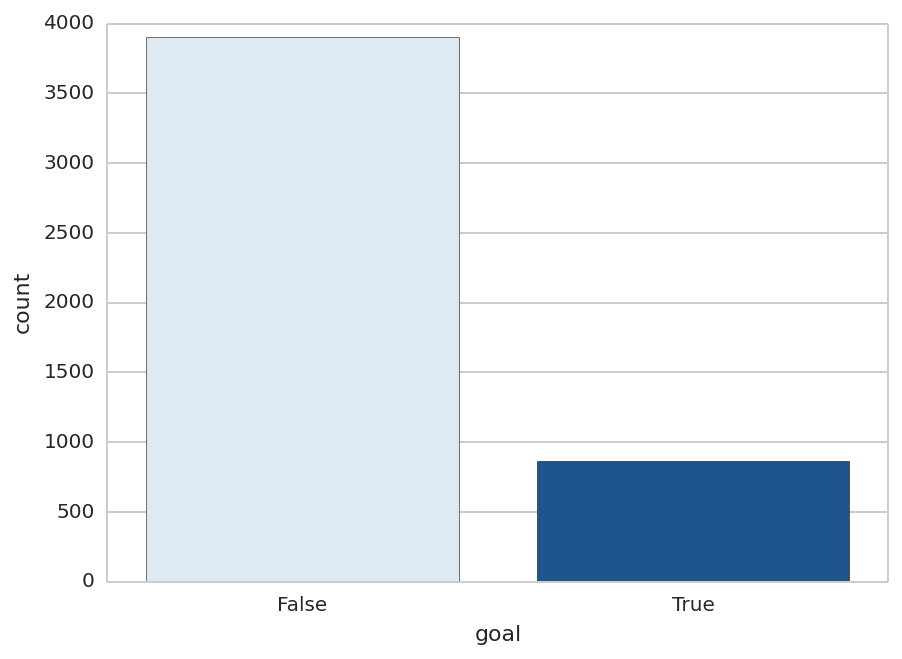

In [9]:
mpl.rcParams['figure.figsize'] = (7,5)
# palette = sns.diverging_palette(220, 10, sep=80, n=2)
palette = [sns.color_palette("Blues")[0], sns.color_palette("Blues")[-1]]
sns.countplot(x="goal", data=shots_df, palette=palette)
plt.show()

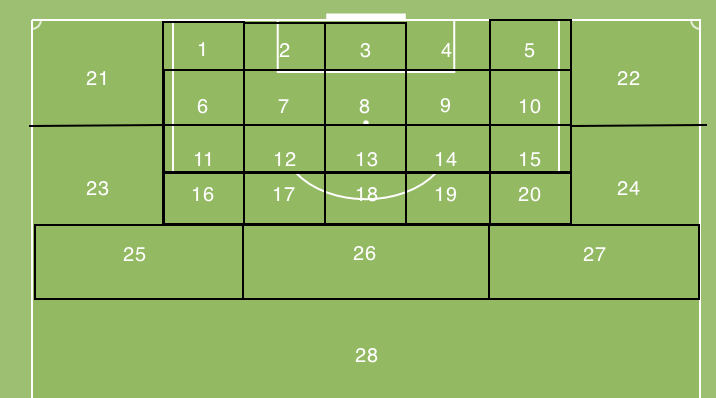

In [10]:
Image(filename = "map.png", width=500, height=500)
# region assistance = 0 means no assistance

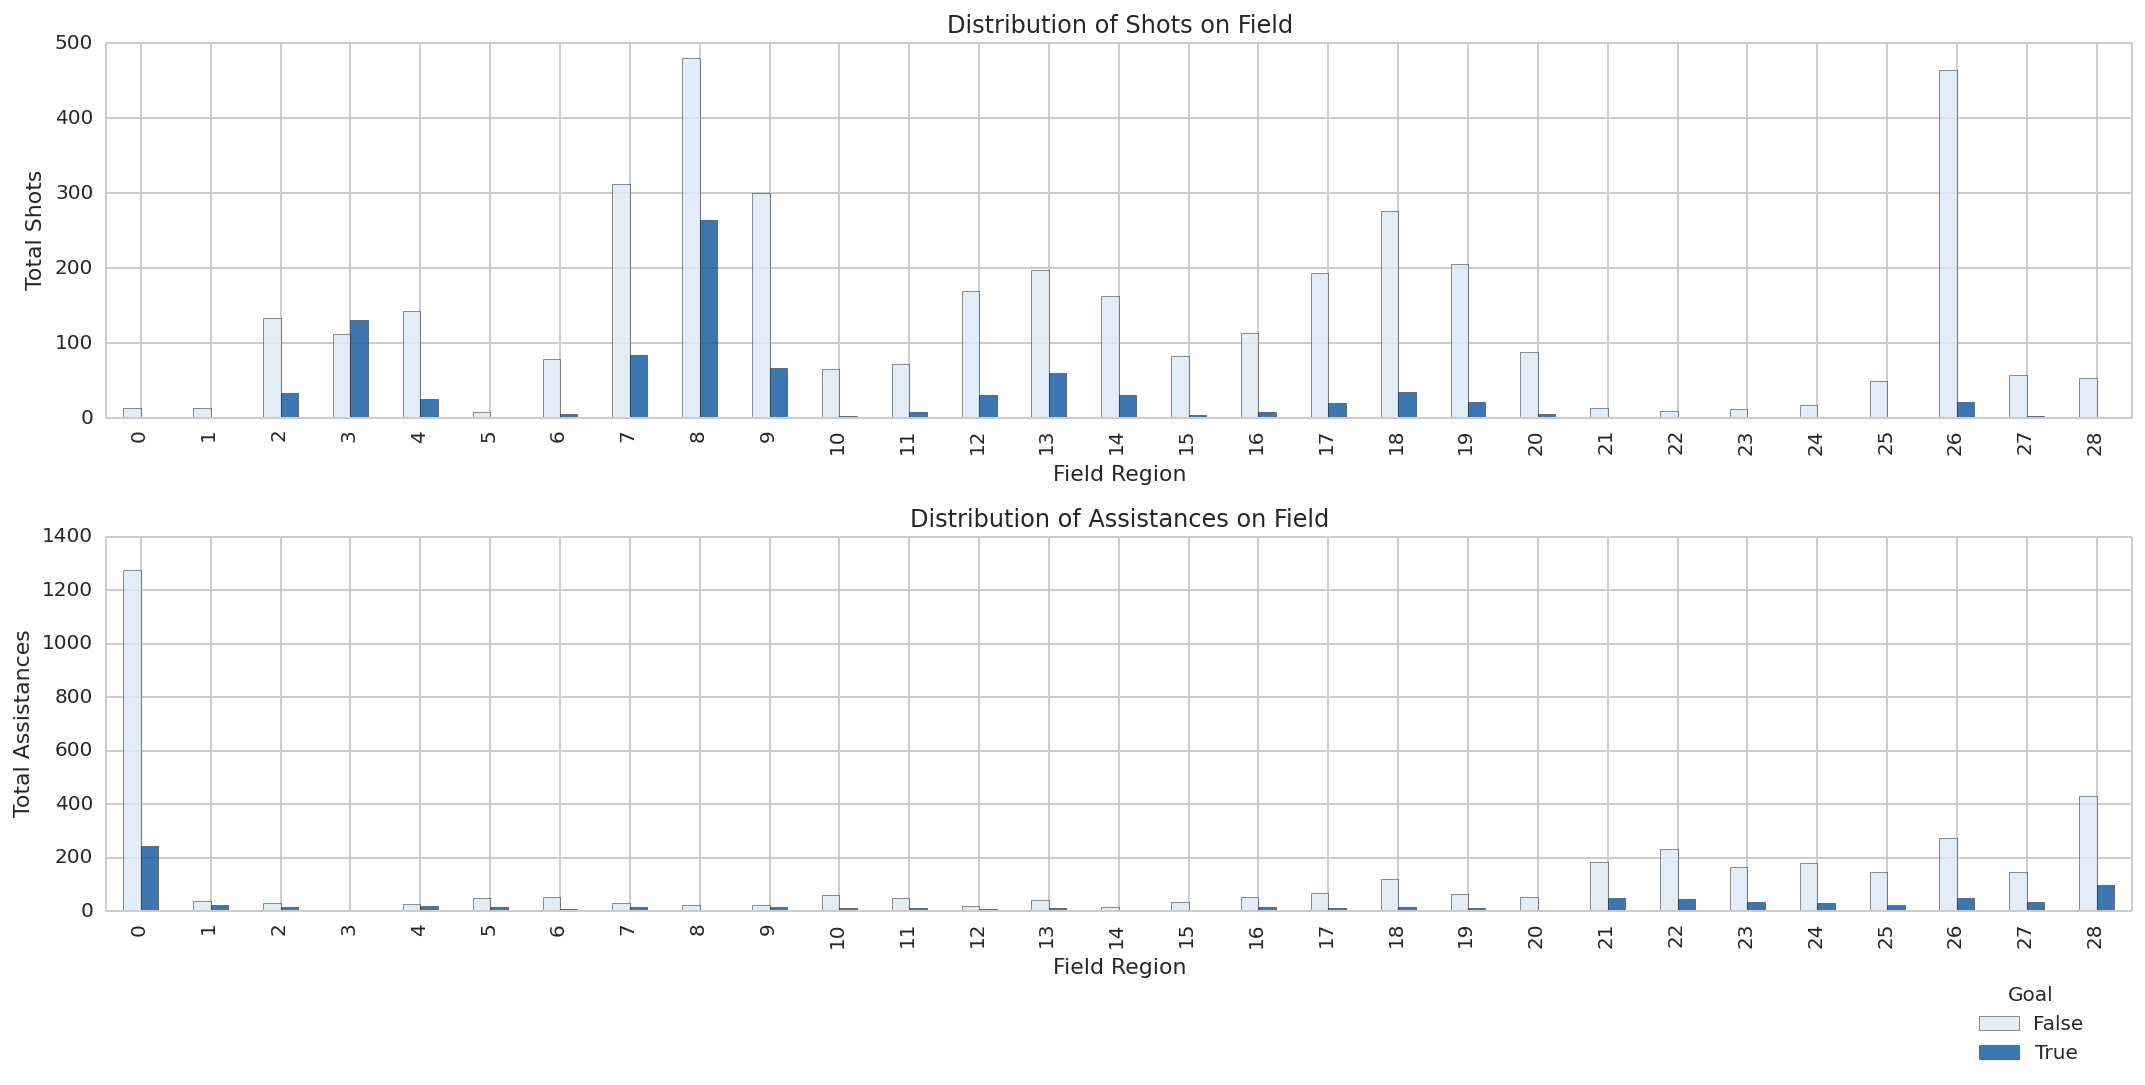

In [11]:
mpl.rcParams['figure.figsize'] = (15,7)
fig,(ax1,ax2) = plt.subplots(2)

pd.crosstab(shots_df.region_shot,shots_df.goal).plot(kind='bar', color=palette, alpha=0.8, ax=ax1)
ax1.set_title('Distribution of Shots on Field')
ax1.set_xlabel('Field Region')
ax1.set_ylabel('Total Shots')
ax1.legend().set_visible(False)

pd.crosstab(shots_df.region_assistance,shots_df.goal).plot(kind='bar', color=palette, alpha=0.8, ax=ax2)
ax2.set_title('Distribution of Assistances on Field')
ax2.set_xlabel('Field Region')
ax2.set_ylabel('Total Assistances')
ax2.legend(loc=9, bbox_to_anchor=(0.95, -0.15), title="Goal")
fig.tight_layout()


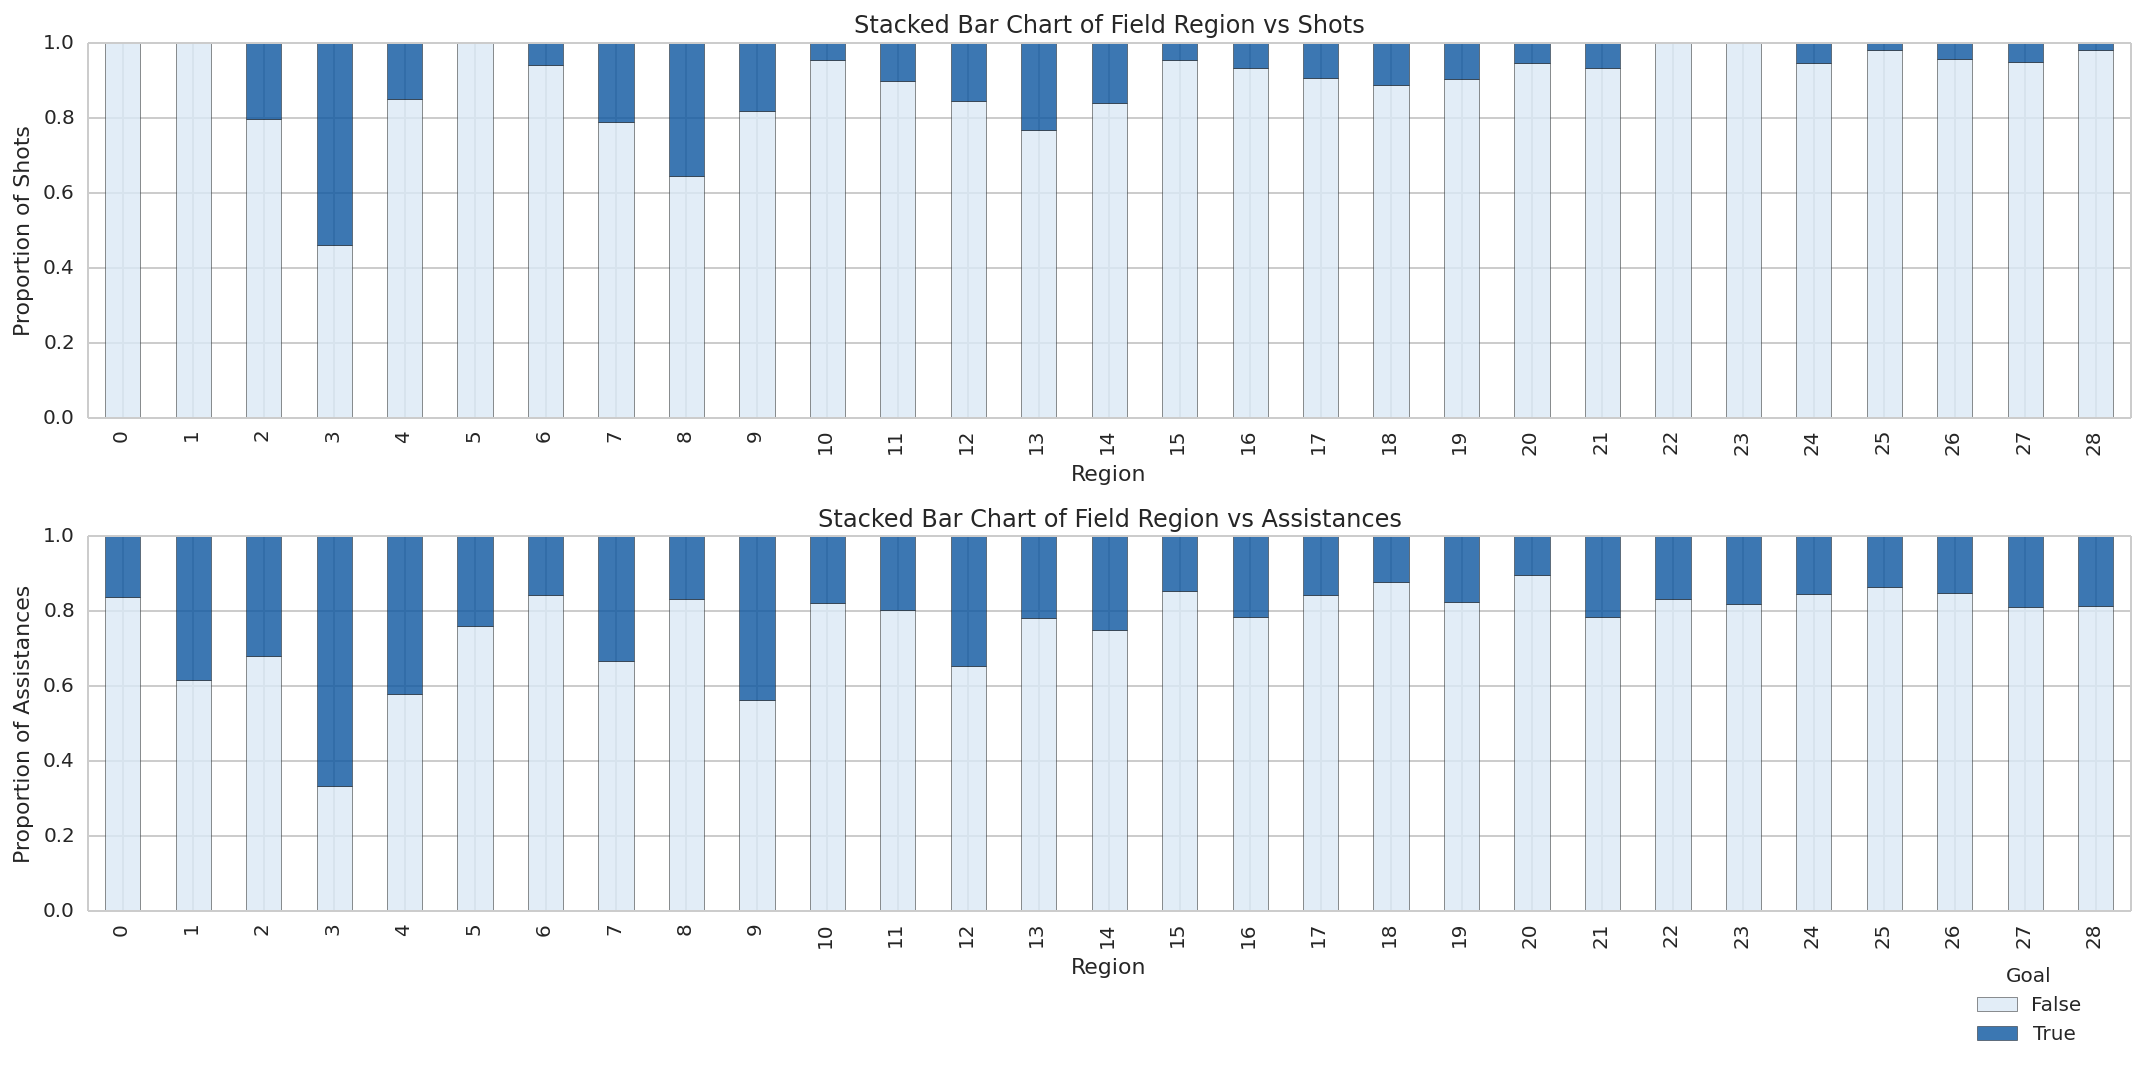

In [12]:
mpl.rcParams['figure.figsize'] = (15,7)
fig,(ax1,ax2) = plt.subplots(2)

table=pd.crosstab(shots_df.region_shot,shots_df.goal)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, color=palette, alpha=0.8, ax=ax1)
ax1.set_title('Stacked Bar Chart of Field Region vs Shots')
ax1.set_xlabel('Region')
ax1.set_ylabel('Proportion of Shots')
ax1.legend().set_visible(False)

table=pd.crosstab(shots_df.region_assistance,shots_df.goal)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, color=palette, alpha=0.8, ax=ax2)
ax2.set_title('Stacked Bar Chart of Field Region vs Assistances')
ax2.set_xlabel('Region')
ax2.set_ylabel('Proportion of Assistances')
ax2.legend(loc=9, bbox_to_anchor=(0.95, -0.1), title="Goal")
fig.tight_layout()


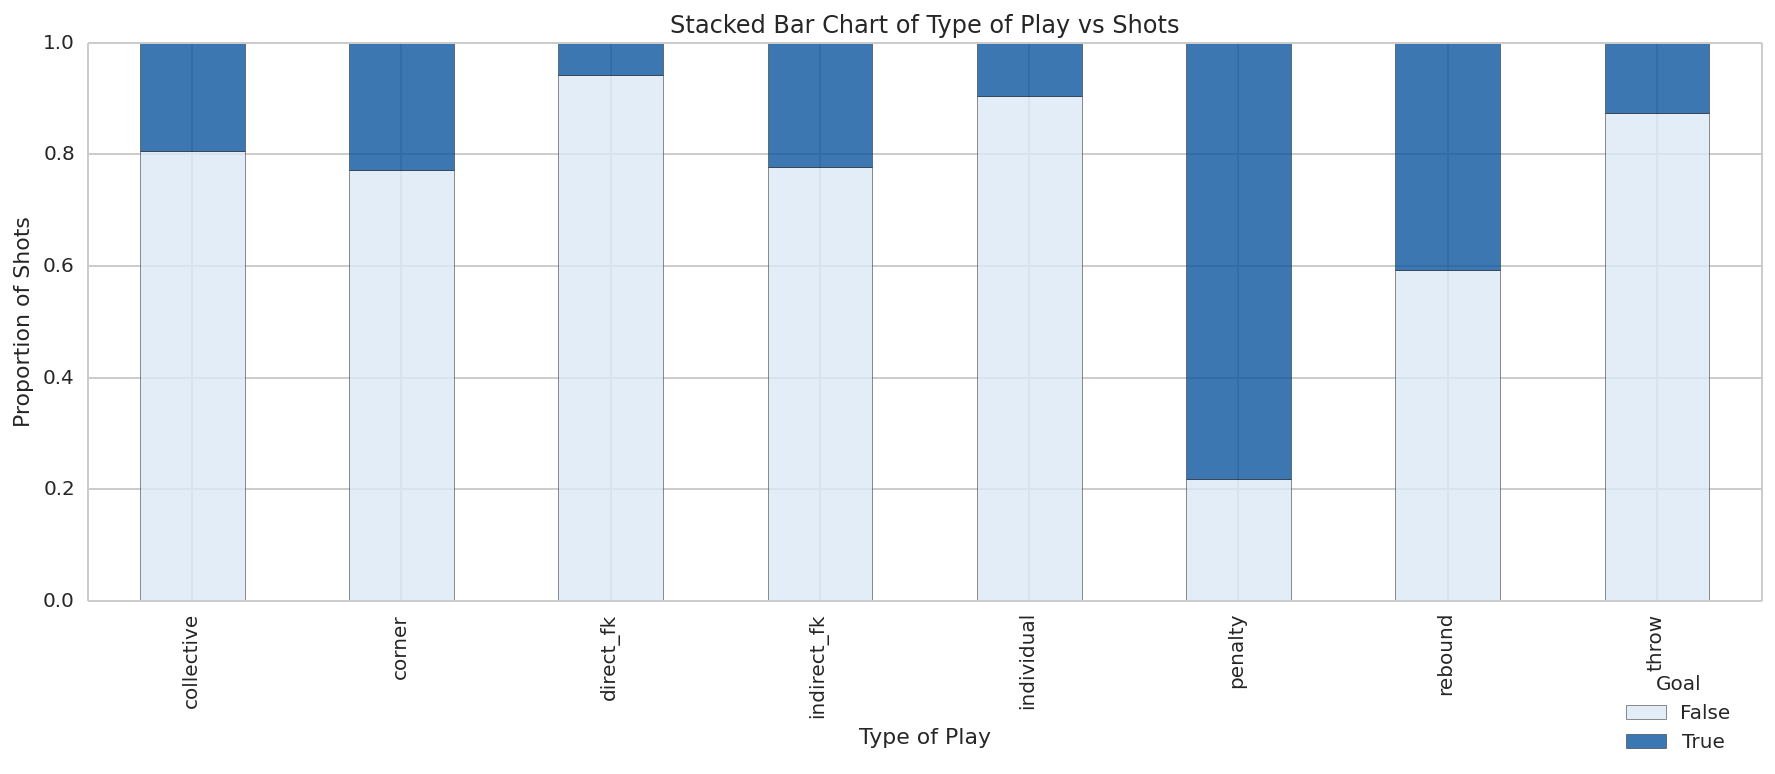

In [13]:
mpl.rcParams['figure.figsize'] = (15,5)
table=pd.crosstab(shots_df.type_of_play,shots_df.goal)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, color=palette, alpha=0.8)
plt.title('Stacked Bar Chart of Type of Play vs Shots')
plt.xlabel('Type of Play')
plt.ylabel('Proportion of Shots')
plt.legend(loc=9, bbox_to_anchor=(0.95, -0.1), title="Goal")

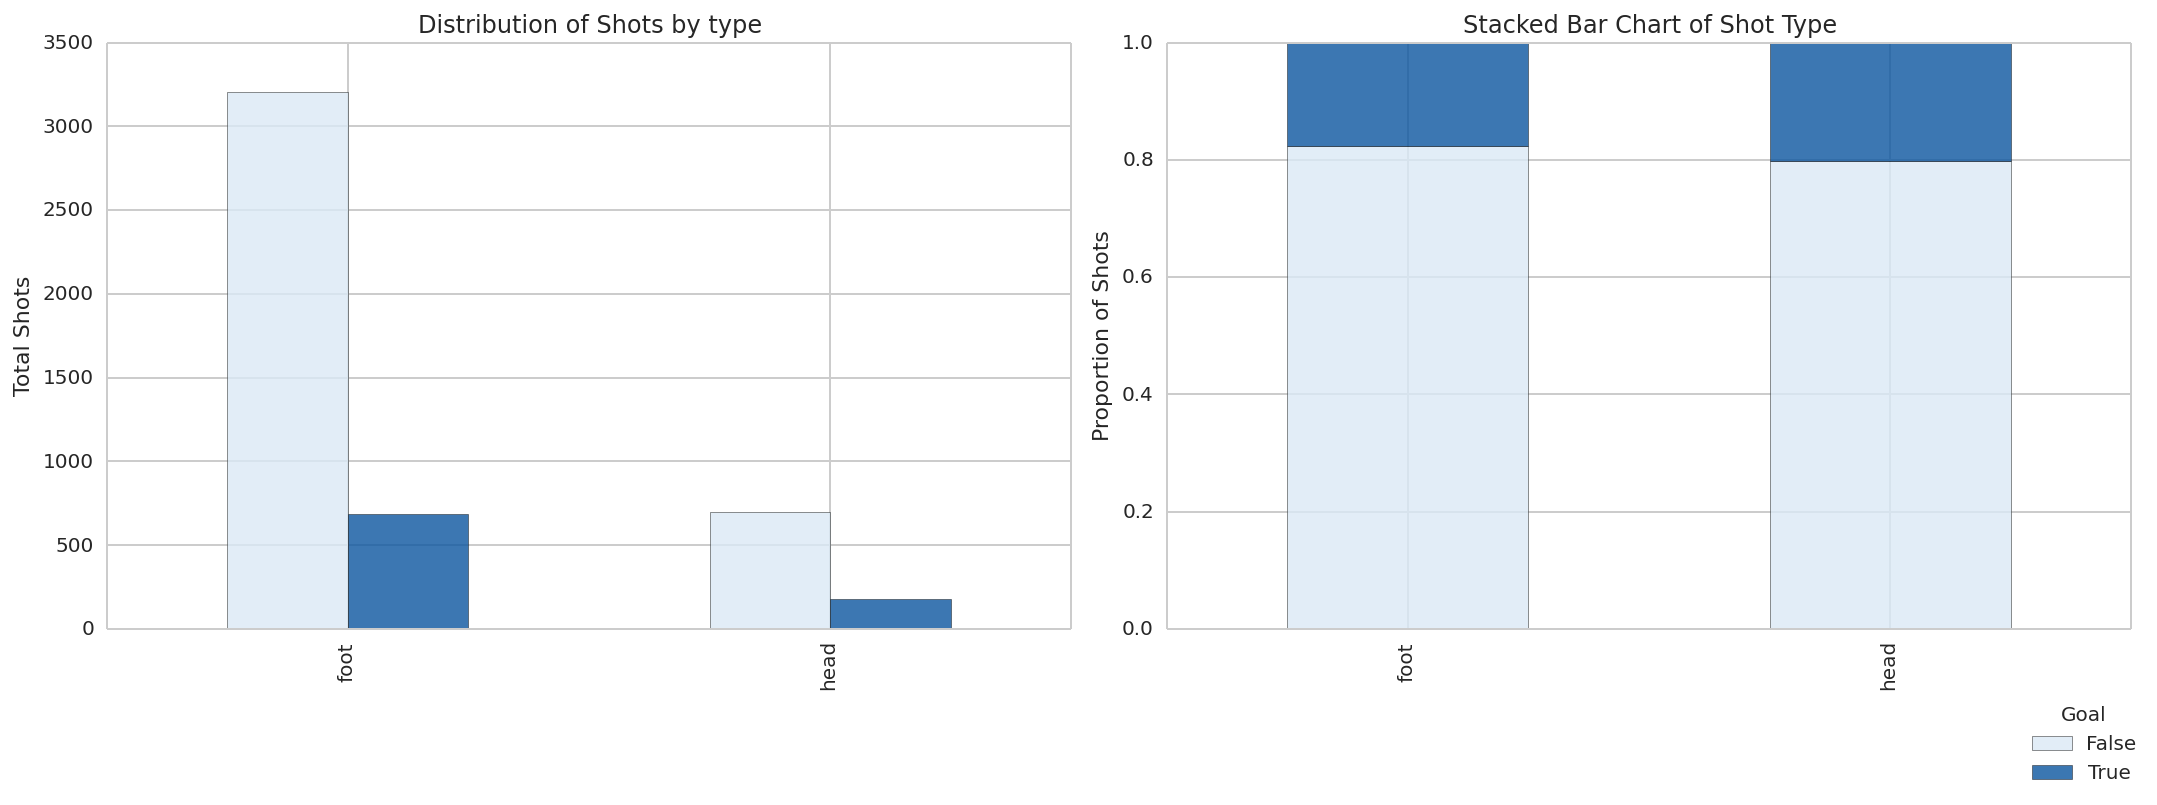

In [14]:
mpl.rcParams['figure.figsize'] = (15,5)
fig,(ax1,ax2) = plt.subplots(1,2)

pd.crosstab(shots_df.type_of_shot,shots_df.goal).plot(kind='bar', color=palette, alpha=0.8, ax=ax1)
ax1.set_title('Distribution of Shots by type')
ax1.set_xlabel('')
ax1.set_ylabel('Total Shots')
ax1.legend().set_visible(False)

table=pd.crosstab(shots_df.type_of_shot,shots_df.goal)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, color=palette, alpha=0.8, ax=ax2)
ax2.set_title('Stacked Bar Chart of Shot Type')
ax2.set_xlabel('')
ax2.set_ylabel('Proportion of Shots')
ax2.legend(loc=9, bbox_to_anchor=(0.95, -0.1), title="Goal")
fig.tight_layout()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

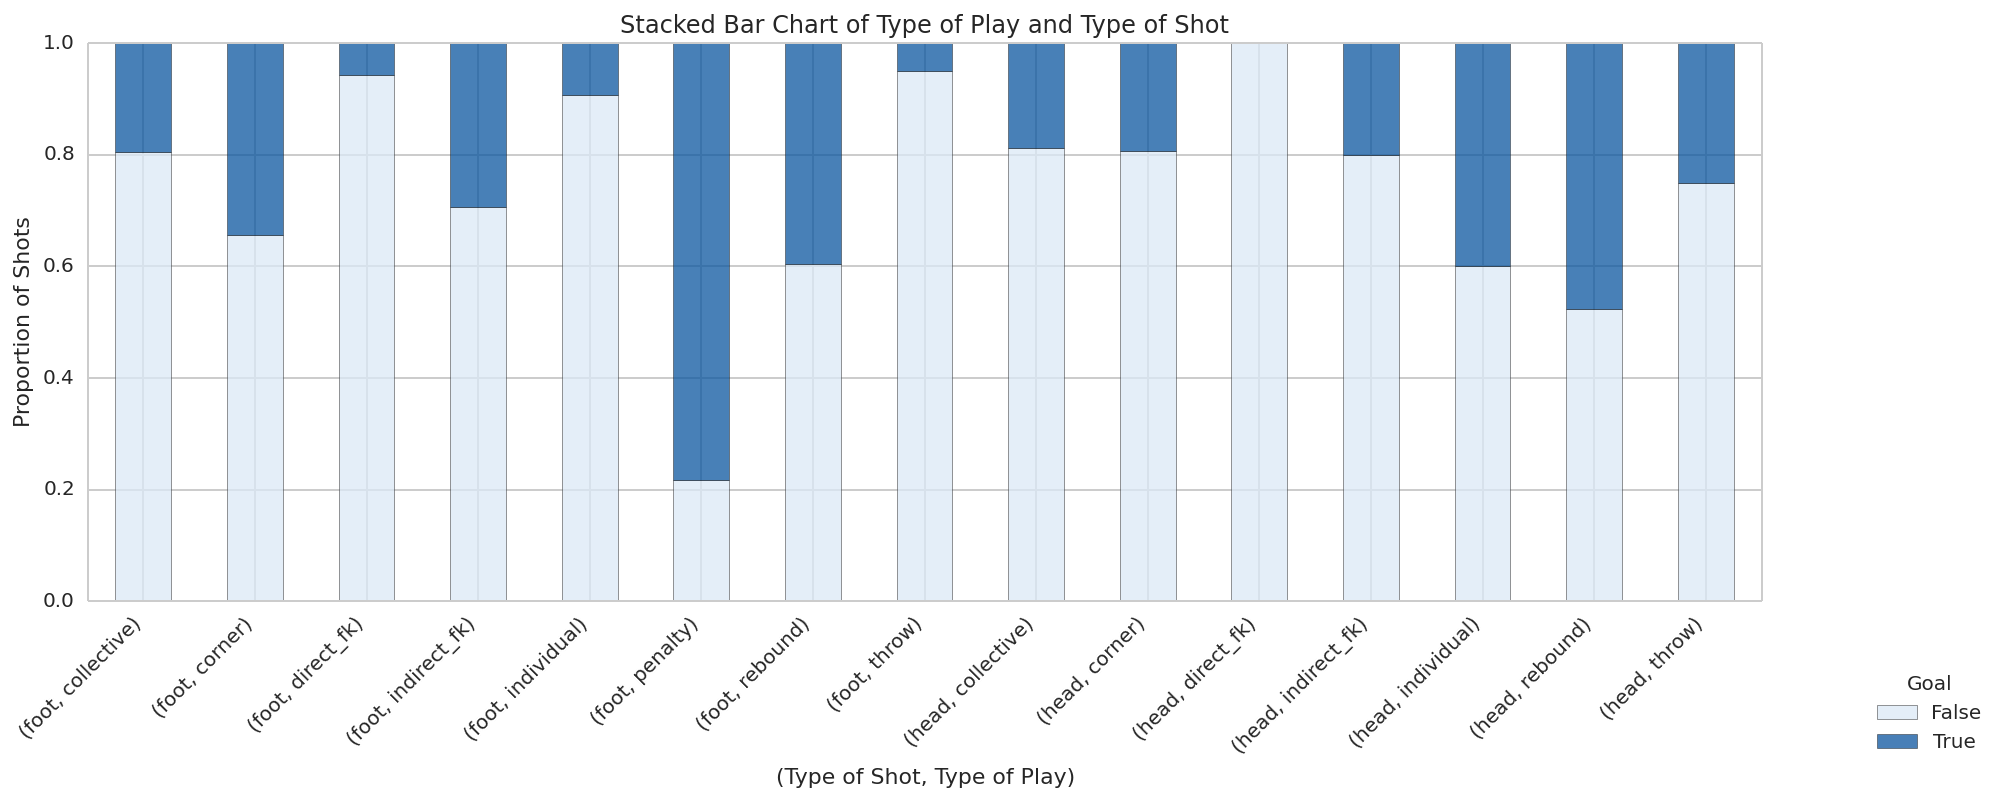

In [38]:
mpl.rcParams['figure.figsize'] = (15,5)

table=pd.crosstab([shots_df.type_of_shot,shots_df.type_of_play],shots_df.goal)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, color=palette, alpha=0.75, rot=45)
plt.title('Stacked Bar Chart of Type of Play and Type of Shot')
plt.xlabel('(Type of Shot, Type of Play)')
plt.ylabel('Proportion of Shots')
plt.legend(loc=9, bbox_to_anchor=(1.1, -0.1), title="Goal")
plt.xticks(ha='right')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

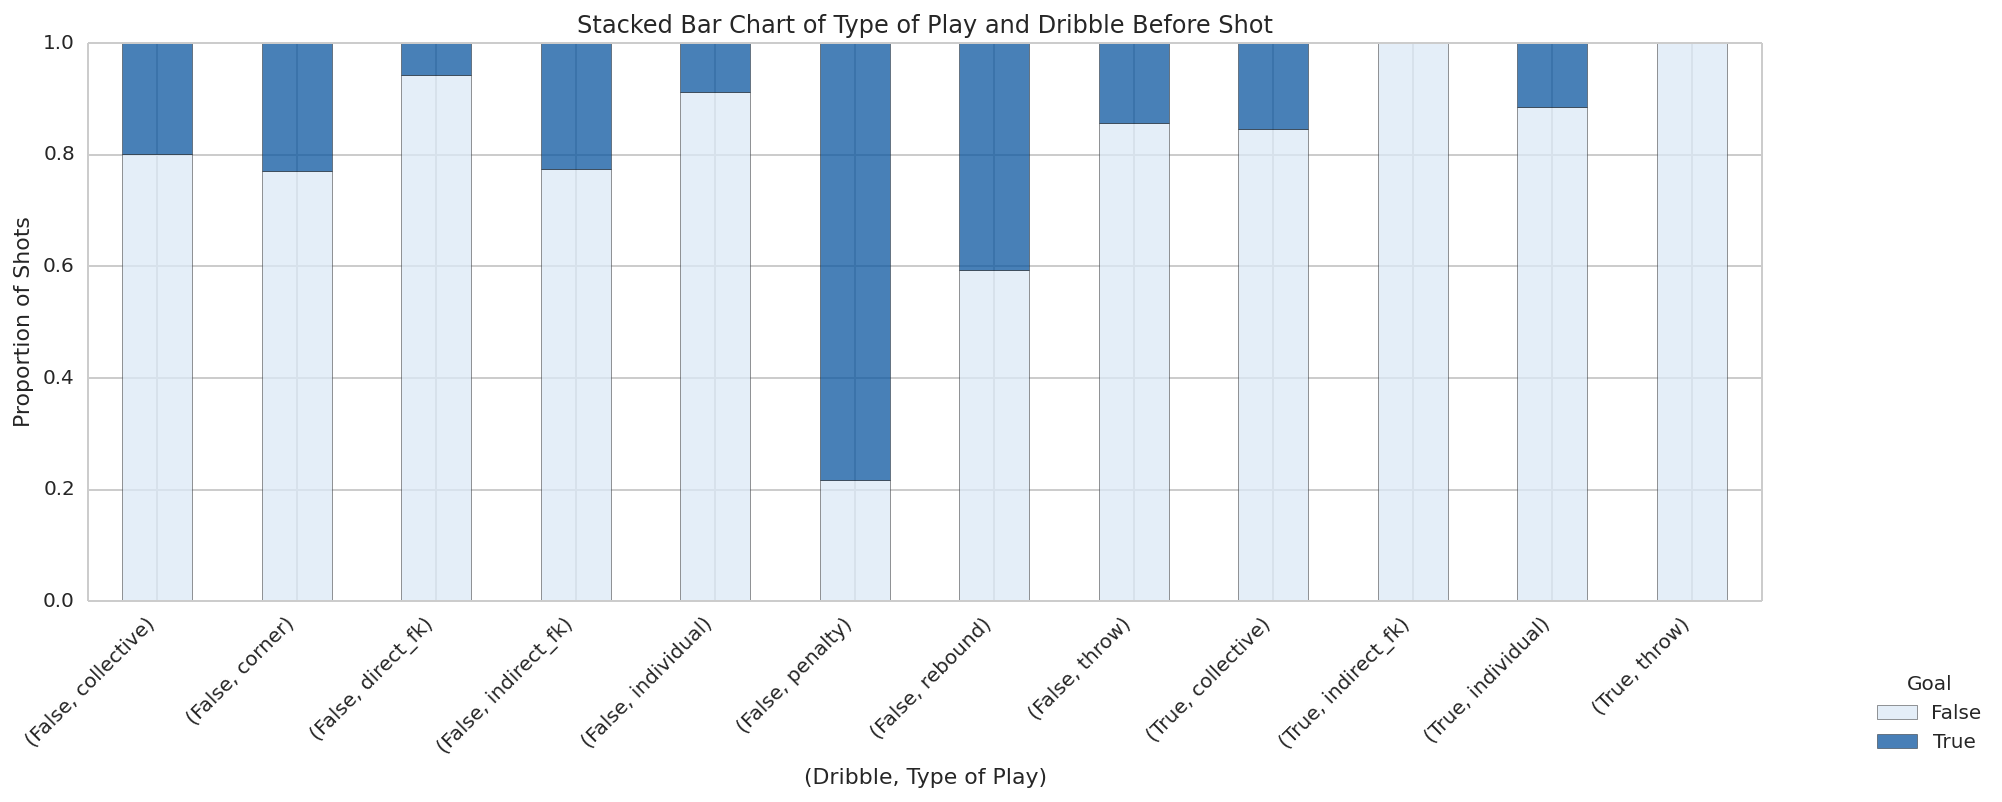

In [39]:
mpl.rcParams['figure.figsize'] = (15,5)

table=pd.crosstab([shots_df.dribble_before_shot,shots_df.type_of_play],shots_df.goal)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, color=palette, alpha=0.75, rot=45)
plt.title('Stacked Bar Chart of Type of Play and Dribble Before Shot')
plt.xlabel('(Dribble, Type of Play)')
plt.ylabel('Proportion of Shots')
plt.legend(loc=9, bbox_to_anchor=(1.1, -0.1), title="Goal")
plt.xticks(ha='right')

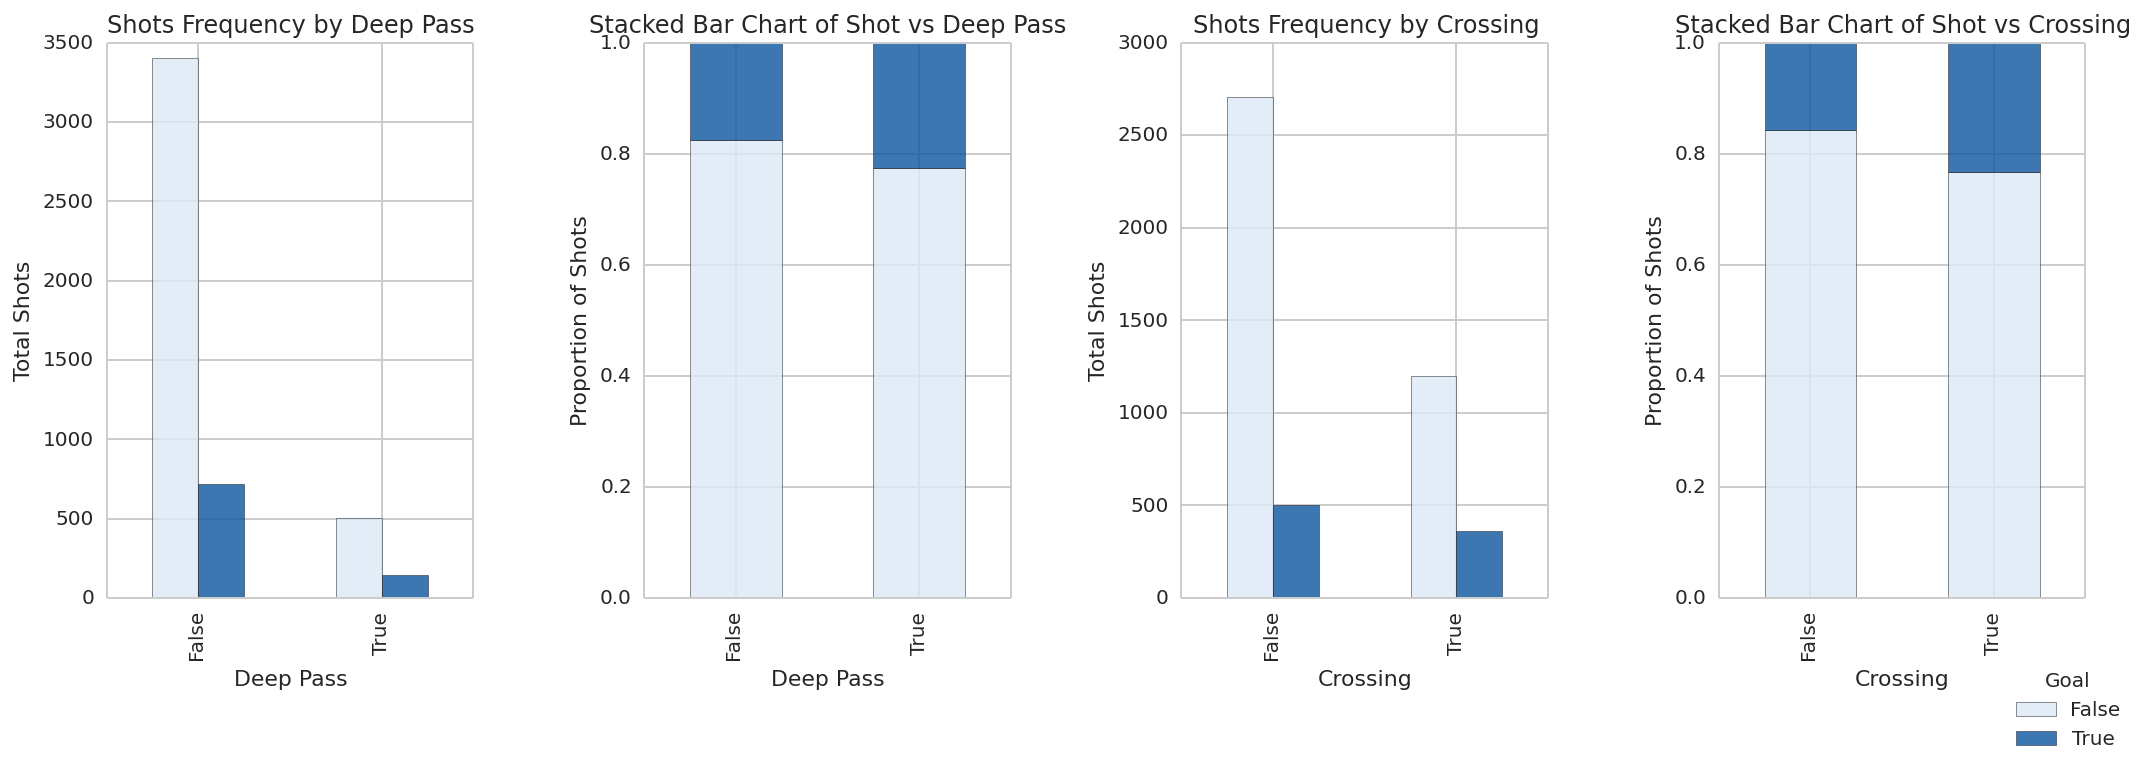

In [40]:
mpl.rcParams['figure.figsize'] = (15,5)
fig,(ax1,ax2,ax3,ax4) = plt.subplots(1,4)

pd.crosstab(shots_df.deep_pass,shots_df.goal).plot(kind='bar', color=palette, alpha=0.8, ax=ax1)
ax1.set_title('Shots Frequency by Deep Pass')
ax1.set_xlabel('Deep Pass')
ax1.set_ylabel('Total Shots')
ax1.legend().set_visible(False)

table=pd.crosstab(shots_df.deep_pass,shots_df.goal)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, color=palette, alpha=0.8, ax=ax2)
ax2.set_title('Stacked Bar Chart of Shot vs Deep Pass')
ax2.set_xlabel('Deep Pass')
ax2.set_ylabel('Proportion of Shots')
ax2.legend().set_visible(False)

pd.crosstab(shots_df.cross,shots_df.goal).plot(kind='bar', color=palette, alpha=0.8, ax=ax3)
ax3.set_title('Shots Frequency by Crossing')
ax3.set_xlabel('Crossing')
ax3.set_ylabel('Total Shots')
ax3.legend().set_visible(False)

table=pd.crosstab(shots_df.cross,shots_df.goal)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, color=palette, alpha=0.8, ax=ax4)
ax4.set_title('Stacked Bar Chart of Shot vs Crossing')
ax4.set_xlabel('Crossing')
ax4.set_ylabel('Proportion of Shots')
ax4.legend(loc=9, bbox_to_anchor=(0.95, -0.1), title="Goal")
fig.tight_layout()

# Matches data

In [44]:
match_df.head()

,week,home_team,away_team,home_goals,away_goals,week_day,time,home_passes,home_wrong_passes,away_passes,...,home_shots_on_target,home_shots_off_target,away_shots_on_target,away_shots_off_target,home_fouls,away_fouls,home_tackles,home_wrong_tackles,away_tackles,away_wrong_tackles
0,1,Flamengo,Sport,1,0,SAT,16,471,41,322,...,5,6,1,0,18,15,24,1,19,3
1,1,Atletico MG,Santos,1,0,SAT,18,249,37,444,...,6,15,4,8,17,11,26,6,9,2
2,1,Coritiba,Cruzeiro,1,0,SAT,21,304,41,349,...,6,8,1,3,20,22,17,3,19,2
3,1,Corinthians,Gremio,0,0,SUN,16,470,44,283,...,1,15,2,4,12,19,24,1,22,3
4,1,Botafogo,Sao Paulo,0,1,SUN,11,434,32,189,...,6,5,1,3,8,10,9,1,17,4


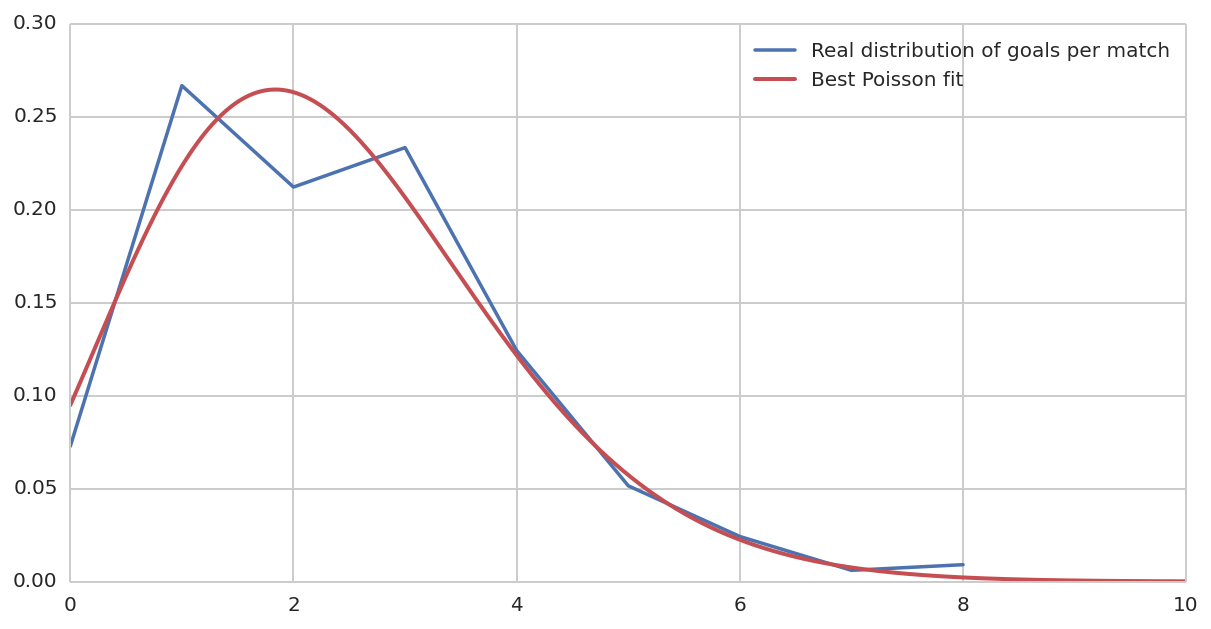

In [113]:
goals_per_match = []
for k in range(len(match_df["home_goals"])):
    goals_per_match.append(match_df["home_goals"][k]+match_df["away_goals"][k])

goals, percentage_of_goals = zip(*[[goals,goals_per_match.count(goals)/float(len(match_df["home_goals"]))] for goals in set(goals_per_match)])

def poisson(k, lamb):
    return (lamb**k/factorial(k)) * np.exp(-lamb)

parameters, cov_matrix = curve_fit(poisson, goals, percentage_of_goals)

mpl.rcParams['figure.figsize'] = (10,5)
plt.plot(goals,percentage_of_goals,label="Real distribution of goals per match")
x_plot = np.linspace(0, 10, 1000)
plt.plot(x_plot, poisson(x_plot, *parameters), 'r-', lw=2, label="Best Poisson fit")
plt.legend()
plt.show()


# Logistic Regression

In [115]:
cat_vars=['region_assistance','region_shot','type_of_play','type_of_shot','dribble_before_shot','deep_pass','cross',
              'counter_attack']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(shots_df[var], prefix=var)
    data1=shots_df.join(cat_list)
    shots_df=data1

data_vars=shots_df.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]

In [117]:
data_final=shots_df[to_keep]
data_final.columns.values


array(['index', 'week', 'goal', 'minute', 'shot_player',
       'assistance_player', 'team', 'opponent', 'goal_difference',
       'at_home', 'good_chance', 'defense_mistake', 'dangerous_shot',
       'region_assistance_0', 'region_assistance_1', 'region_assistance_2',
       'region_assistance_3', 'region_assistance_4', 'region_assistance_5',
       'region_assistance_6', 'region_assistance_7', 'region_assistance_8',
       'region_assistance_9', 'region_assistance_10',
       'region_assistance_11', 'region_assistance_12',
       'region_assistance_13', 'region_assistance_14',
       'region_assistance_15', 'region_assistance_16',
       'region_assistance_17', 'region_assistance_18',
       'region_assistance_19', 'region_assistance_20',
       'region_assistance_21', 'region_assistance_22',
       'region_assistance_23', 'region_assistance_24',
       'region_assistance_25', 'region_assistance_26',
       'region_assistance_27', 'region_assistance_28', 'region_shot_0',
       'regi

# title 
## major headings 
### subheadings 
#### 4th level subheading